<a href="https://colab.research.google.com/github/abyaadrafid/Deep-Reinforcement-Learning/blob/master/Deep_and_Double_Deep_Q_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installing box2d
This installation is necessary to run LunarLander on colab and kaggle kernels.

I found this workaround from a reddit https://www.reddit.com/r/MLQuestions/comments/fpxitj/need_help_getting_lunarlanderv2_from_openaigym_to/

In [0]:
!apt install swig cmake libopenmpi-dev zlib1g-dev
!pip install stable-baselines[mpi]==2.10.0 box2d box2d-kengz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2).
libopenmpi-dev is already the newest version (2.1.1-8).
swig is already the newest version (3.0.12-1).
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.


### Doing imports

In [0]:
import random
import sys
from time import time
from collections import deque, defaultdict, namedtuple
import numpy as np
import pandas as pd
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from google.colab import drive 
%matplotlib inline

plt.style.use('seaborn')

### Setting up our environment

In [0]:
env = gym.make('LunarLander-v2')
env.seed(0)
print(env.action_space)
print(env.observation_space)

Discrete(4)
Box(8,)


In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Template for Deep Network
In the context of Deep Q Learning and its other variants, neural networks are used as the Q table. This class will serve as the template neural network and will be used throughout the whole experiment.

The neural network of the agents can be arbitrarily deep, but we do not need very deep networks for solving the lunar lander environment. Also, as the environment only has 4 actions and 8 dimensional states, only linear layers will suffice. 


We will work with convolutional neural networks with the CartPole environment at some later time.

The network has three linear layers with two relu activations sandwiched within. The final layer does not have any activations because we need the raw outputs from our network to calculate the Q values, unlike classification models that output probabilites.


In [0]:
class DQN(nn.Module):
    def __init__(self, state_size, fc1_size, fc2_size, action_size, seed):
        super(DQN, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_size)
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        self.fc3 = nn.Linear(fc2_size, action_size)  
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x        

###Experience Replay

Experience replay is a technique that allows deep reinforcement learning agents to use memorize and reuse past experiences. When training the network, random samples from the replay memory are used instead of the most recent transition. 

One of the reasons Deep Reinforcement Learning algorithms were not popular was the instability of the networks. This happens because of highly similar training examples when they are sampled subsequently. There might be linear dependece among these samples.

Taking random samples breaks the similarity of subsequent training samples, which otherwise might drive the network into a local minimum.

In [0]:
class ReplayMemory():
    def __init__(self, buffer_size, batch_size, seed):
        self.batch_size = batch_size
        self.seed = random.seed(seed)
        self.memory = deque(maxlen=buffer_size)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    
    def add_experience(self, state, action, reward, next_state, done):
        experience = self.experience(state, action, reward, next_state, done)
        self.memory.append(experience)
                
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([experience.state for experience in experiences if experience is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([experience.action for experience in experiences if experience is not None])).long().to(device)        
        rewards = torch.from_numpy(np.vstack([experience.reward for experience in experiences if experience is not None])).float().to(device)        
        next_states = torch.from_numpy(np.vstack([experience.next_state for experience in experiences if experience is not None])).float().to(device)  
        dones = torch.from_numpy(np.vstack([experience.done for experience in experiences if experience is not None]).astype(np.uint8)).float().to(device)        
        
        return (states, actions, rewards, next_states, dones)
        
    def __len__(self):
        return len(self.memory)
    

### Environment and Agent Hyperparameters

#### Exploration- Exploitation tradeoff

One of the most basic ideas in RL is the exploration-exploitation tradeoff. It's basically a dilemma about what action to take in a certain state. The agent can take a random action, which can result in a better/worse reward; or it can take an action that it already knows the reward of. Now, if the agent keeps taking the known actions, (in other words keeps exploiting the actions), it may never explore all of the action-state space and may never find the optimal action for that state.

A thought experiment should help clear out the idea. Let's say you go to a new restaurant and randomly order a food from the menu. The food arrives and you moderately like it. Next time you visit the restaurant again, you have two choices : either reorder the food you already moderately like or order another random food from the menu. In other words, you can *exploit* your prior knowledge about the menu, or you can *explore* more things about the menu.
You might find the new food better, which will increase your reward. But you could also find it worse, which will decrease your reward. Assuming your goal is to maximize your reward aggregated thorughtout all the times you visit the restaurant, this posits a dilemma. This is the exploitation-exploration tradeoff. 

The exploration-exploitation needs to be adjusted for an agent to perform well. An agent that does too much exploration does not maximize the reward, and the agent that does not exploit enough might never find the maximum reward for any action.

To control how much our agent explores/exploits, we use a hyperparameter named epsilon. It basically detones the probability of taking exploratory (random) action for a given state.

In [0]:
EPS_START = 1.0    
EPS_DECAY = 0.999    
EPS_MIN = 0.01

We start with an epsilon of 1 and then decay it over time with a factor of 0.999. We still want to keep some exploration for our agent. So we fix the lowest epsilon value that it doesn't become too small.

In [0]:
TAU = 1e-3              
LR = 1e-4        
GAMMA = 0.99           
UPDATE_EVERY = 4      
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 64    

In [0]:
FC1_SIZE = 128
FC2_SIZE = 256   
    
MAX_EPISODES = 2000  
MAX_STEPS = 1000     
ENV_SOLVED = 200    
PRINT_EVERY = 100    

### Deep Q Agent

This is an agent with a Replay Memory and one deep q network. This is the simplest form of Deep Q Learning agent that actually works.

In [0]:
class DeepQAgent():
    def __init__(self, state_size,fc1_size,fc2_size, action_size, seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)


        self.q_network = DQN(state_size, fc1_size, fc2_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.q_network.parameters())

        self.memory = ReplayMemory(BUFFER_SIZE, BATCH_SIZE, seed)
        self.timestep = 0
        
    def step(self, state, action, reward, next_state, done):
        self.memory.add_experience(state, action, reward, next_state, done)
        self.timestep += 1
        if self.timestep % UPDATE_EVERY == 0:
            if len(self.memory) > BATCH_SIZE:
                sampled_experiences = self.memory.sample()
                self.learn(sampled_experiences)
        
    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences
        
        Q_output = self.q_network(states).gather(1, actions)
        
        action_values = self.q_network(next_states).detach()  
        max_action_values = action_values.max(1)[0].unsqueeze(1)
        Q_target = rewards + GAMMA * max_action_values * (1 - dones)
        
        loss = F.mse_loss(Q_output, Q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def act(self, state, eps=0.0):
        rnd = random.random()
        if rnd < eps:
            return np.random.randint(self.action_size)
        else:
            state = torch.from_numpy(state).float().unsqueeze(0).to(device)

            self.q_network.eval()
            with torch.no_grad():
                action_values = self.q_network(state)

            self.q_network.train()
            action = np.argmax(action_values.cpu().data.numpy())
            return action    
        
    def checkpoint(self, filename):
        torch.save(self.q_network.state_dict(), filename)

### Double Deep Q Agent with a Target Network

In the previous version we used the same q network to obtain our Q target and Q eval. We can also use two different networks to get two of our values. We'll keep one of the networks fixed and call it a target network. 

#### Why use a target network




In [0]:
class DoubleDeepQAgent():
  def __init__(self, state_size, fc1_size, fc2_size, action_size, seed = 0):
    self.state_size = state_size
    self.action_size = action_size
    self.seed = random.seed(seed)

    self.q_network = DQN(self.state_size, fc1_size, fc2_size, self.action_size, seed).to(device)
    self.target_network = DQN(self.state_size, fc1_size, fc2_size, self.action_size, seed).to(device)
    self.optimizer = optim.Adam(self.q_network.parameters())

    self.memory = ReplayMemory(BUFFER_SIZE, BATCH_SIZE, seed)
    self.timestep =0

  def step(self, state, action, reward, next_state, done):
    self.memory.add_experience(state, action, reward, next_state, done)
    self.timestep +=1
    if self.timestep % UPDATE_EVERY == 0:
      if len(self.memory) > BATCH_SIZE:
        sampled_experience = self.memory.sample()
        self.learn(sampled_experience)

  def learn(self, experiences):
    states, actions, rewards, next_states, dones = experiences 
    
    Q_output = self.q_network(states).gather(1, actions)

    action_values = self.target_network(next_states).detach()
    max_action_values = action_values.max(1)[0].unsqueeze(1)
    Q_target = rewards + GAMMA * max_action_values * (1 - dones)

    loss = F.mse_loss(Q_output, Q_target)

    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    self.update_target_network(self.q_network, self.target_network)

  def update_target_network(self, source_network, target_network):
    for source_parameters, target_parameters in zip(source_network.parameters(), target_network.parameters()):
      target_parameters.data.copy_(TAU * source_parameters.data + (1- TAU) * target_parameters.data)

  def act(self, state, eps=0.0):
    rnd = random.random()
    if rnd < eps:
      return np.random.randint(self.action_size)
    else:
      state = torch.from_numpy(state).float().unsqueeze(0).to(device)

      self.q_network.eval()
      with torch.no_grad():
        action_values = self.q_network(state)

      self.q_network.train()
      action = np.argmax(action_values.cpu().data.numpy())
      return action    
        
  def checkpoint(self, filename):
    torch.save(self.q_network.state_dict(), filename)

In [0]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

print('State size: {}, action size: {}'.format(state_size, action_size))

State size: 8, action size: 4


In [0]:
def train(dqn_agent):
  start = time()
  scores = []

  scores_window = deque(maxlen=100)
  eps = EPS_START
  for episode in range(1, MAX_EPISODES + 1):
      state = env.reset()
      score = 0
      for t in range(MAX_STEPS):
          action = dqn_agent.act(state, eps)
          next_state, reward, done, info = env.step(action)
          dqn_agent.step(state, action, reward, next_state, done)
          state = next_state        
          score += reward        
          if done:
              break
              
          eps = max(eps * EPS_DECAY, EPS_MIN)
          if episode % PRINT_EVERY == 0:
              mean_score = np.mean(scores_window)
              print('\r Progress {}/{}, average score:{:.2f}'.format(episode, MAX_EPISODES, mean_score), end="")
          if score >= ENV_SOLVED:
              mean_score = np.mean(scores_window)
              print('\rEnvironment solved in {} episodes, average score: {:.2f}'.format(episode, mean_score), end="")
              sys.stdout.flush()
              dqn_agent.checkpoint('solved_200.pth')
              break
              
      scores_window.append(score)
      scores.append(score)
      
  end = time()    
  print('Took {} seconds'.format(end - start))

  return scores

In [0]:
dqn_agent = DeepQAgent(state_size, FC1_SIZE, FC2_SIZE, action_size, seed=0)

In [0]:
ddqn_agent = DoubleDeepQAgent(state_size, FC1_SIZE, FC2_SIZE, action_size, seed=0)

In [0]:
dqn_scores = train(dqn_agent)
ddqn_scores = train(ddqn_agent)

 Progress 2000/2000, average score:250.97Took 1386.8975994586945 seconds
 Progress 2000/2000, average score:240.81Took 1959.8139865398407 seconds


In [0]:
def plot(score, string):
  plt.figure(figsize=(10,6))
  plt.plot(score)
  plt.plot(pd.Series(score).rolling(100).mean())
  plt.title('%s Training,'%string)
  plt.xlabel('# of episodes')
  plt.ylabel('score')
  plt.show()


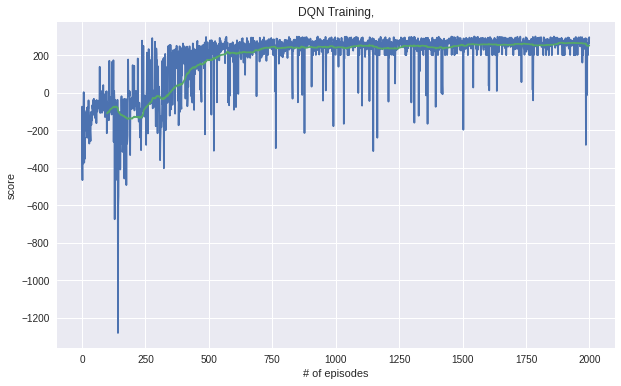

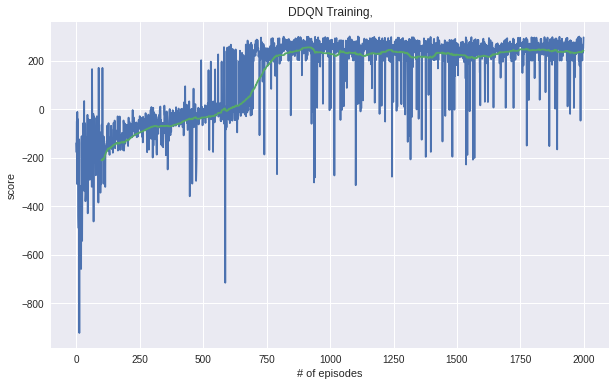

In [0]:
plot(dqn_scores, 'DQN')
plot(ddqn_scores, 'DDQN')